In [344]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pyaudio     #sudo apt-get install python-pyaudio
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import re

In [388]:
epochs = 200
stepsPerEpochs= 20
VALIDATION_SIZE = 1
BATCH_SIZE = 128
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
seq_length = 5


# load ascii text and covert to lowercase
#filename = "wonderlandFull.txt"
#filenameTest = "wonderlandTest.txt"
filename = "MusicTrain.txt"
filenameTest = "MusicTest.txt"

In [409]:

notas = pd.read_csv('notas.csv')
notas

,Número da tecla,Notação de Helmholtz,Notação científica (SPN),Frequência (Hz),Violino,Viola,Cello,Contrabaixo,Guitarra
0,108,b′′′′′,B8,"7902,133",NaN,NaN,NaN,NaN,NaN
1,107,a♯′′′′′/b♭′′′′′,A♯8/B♭8,"7458,620",NaN,NaN,NaN,NaN,NaN
2,106,a′′′′′,A8,"7040,000",NaN,NaN,NaN,NaN,NaN
3,105,g♯′′′′′/a♭′′′′′,G♯8/A♭8,"6644,875",NaN,NaN,NaN,NaN,NaN
4,104,g′′′′′,G8,"6271,927",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
102,94,F͵͵,F0,"21,82676",NaN,NaN,NaN,NaN,NaN
103,93,E͵͵,E0,"20,60172",NaN,NaN,NaN,NaN,NaN
104,92,D♯͵͵/E♭͵͵,D♯0/E♭0,"19,44544",NaN,NaN,NaN,NaN,NaN
105,91,D͵͵,D0,"18,35405",NaN,NaN,NaN,NaN,NaN


In [390]:
def proccessedText(filetxt):
    raw_text = open(filetxt, 'r', encoding='utf-8').read()

    pattern = re.compile(r'([A-Z][♭♯]{0,1}[0-9])')
    processedText=''
    for m in re.finditer(pattern, raw_text):

        t = notas[notas['Notação científica (SPN)'].str.contains(m.group(1))]

        try:
            processedText += chr(t['Número da tecla'].values[0])
        except:
            print("err")
    return processedText

In [391]:
processedTrainText = "processedTrainText.txt"


f = open(processedTrainText, "w")
f.write(proccessedText(filename))
f.close()

processedTestText = "processedTestText.txt"


f = open(processedTestText, "w")
f.write(proccessedText(filenameTest))
f.close()

In [392]:

# create mapping of unique chars to integers
chars = [chr(n) for n in notas['Número da tecla'].unique().tolist()]

char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(processedText)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  171
Total Vocab:  107


In [393]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1), return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(char_to_int), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [394]:

if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [395]:

# Load data
def generate_arrays_from_file(path, batchsize):
    dataX = []
    dataY = []
    batchcount = 0
    while True:
        with open(path) as f:
            raw_text = f.read()
            
            for i in range(0, n_chars - seq_length, 1):
                seq_in = raw_text[i:i + seq_length]
                seq_out = raw_text[i + seq_length]
                dataX.append([char_to_int[char] for char in seq_in])
                dataY.append(char_to_int[seq_out])

                batchcount += 1

                if batchcount > batchsize:
                    X = numpy.reshape(dataX, (batchsize+1, seq_length, 1))
                    
                    onehot_encoded = list()

                    for data in dataY:
                        letter = [0 for _ in range(n_vocab)]
                        letter[data] = 1

                        onehot_encoded.append(letter)
                        
                    y = numpy.array(onehot_encoded)
                        
                    #print(len(y[0]),y[0])
                    yield (X, y)                    
                    dataX = []
                    dataY = []
                    batchcount = 0
             

In [396]:
history = model.fit_generator( generate_arrays_from_file(processedTrainText,BATCH_SIZE), epochs=epochs, steps_per_epoch=stepsPerEpochs, verbose=1, validation_data=generate_arrays_from_file(processedTestText,BATCH_SIZE),callbacks = callbacks, validation_steps=10)

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 2.5244 - accuracy: 0.2461
Epoch 00001: loss improved from inf to 2.52436, saving model to weights-improvement-01-2.5244-bigger.hdf5
20/20 [==============================] - 3s 126ms/step - loss: 2.5244 - accuracy: 0.2461 - val_loss: 3.8648 - val_accuracy: 0.0000e+00
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 1.9425 - accuracy: 0.2357
Epoch 00002: loss improved from 2.52436 to 1.94248, saving model to weights-improvement-02-1.9425-bigger.hdf5
20/20 [==============================] - 2s 95ms/step - loss: 1.9425 - accuracy: 0.2357 - val_loss: 3.8748 - val_accuracy: 0.0000e+00
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 1.8940 - accuracy: 0.2659
Epoch 00003: loss improved from 1.94248 to 1.89395, saving model to weights-improvement-03-1.8940-bigger.hdf5
20/20 [==============================] - 2s 100ms/step - loss: 1.8940 - accuracy: 0.2659 - val_loss: 3.9786 - val_accura

20/20 [==============================] - ETA: 0s - loss: 1.4988 - accuracy: 0.3558
Epoch 00026: loss improved from 1.52763 to 1.49877, saving model to weights-improvement-26-1.4988-bigger.hdf5
20/20 [==============================] - 2s 93ms/step - loss: 1.4988 - accuracy: 0.3558 - val_loss: 4.3452 - val_accuracy: 0.1922
Epoch 27/200
20/20 [==============================] - ETA: 0s - loss: 1.4749 - accuracy: 0.3574
Epoch 00027: loss improved from 1.49877 to 1.47486, saving model to weights-improvement-27-1.4749-bigger.hdf5
20/20 [==============================] - 2s 93ms/step - loss: 1.4749 - accuracy: 0.3574 - val_loss: 4.4594 - val_accuracy: 0.1682
Epoch 28/200
20/20 [==============================] - ETA: 0s - loss: 1.4606 - accuracy: 0.3640
Epoch 00028: loss improved from 1.47486 to 1.46062, saving model to weights-improvement-28-1.4606-bigger.hdf5
20/20 [==============================] - 2s 93ms/step - loss: 1.4606 - accuracy: 0.3640 - val_loss: 4.4030 - val_accuracy: 0.1202
Epoch

Epoch 52/200
20/20 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7089
Epoch 00052: loss improved from 0.75238 to 0.72904, saving model to weights-improvement-52-0.7290-bigger.hdf5
20/20 [==============================] - 2s 95ms/step - loss: 0.7290 - accuracy: 0.7089 - val_loss: 7.2636 - val_accuracy: 0.0178
Epoch 53/200
20/20 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.7194
Epoch 00053: loss improved from 0.72904 to 0.69648, saving model to weights-improvement-53-0.6965-bigger.hdf5
20/20 [==============================] - 2s 94ms/step - loss: 0.6965 - accuracy: 0.7194 - val_loss: 7.1958 - val_accuracy: 0.0124
Epoch 54/200
20/20 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7337
Epoch 00054: loss improved from 0.69648 to 0.65976, saving model to weights-improvement-54-0.6598-bigger.hdf5
20/20 [==============================] - 2s 97ms/step - loss: 0.6598 - accuracy: 0.7337 - val_loss: 7.2754 - val_accuracy:

Epoch 78/200
20/20 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8306
Epoch 00078: loss improved from 0.39443 to 0.38185, saving model to weights-improvement-78-0.3818-bigger.hdf5
20/20 [==============================] - 2s 97ms/step - loss: 0.3818 - accuracy: 0.8306 - val_loss: 8.3021 - val_accuracy: 0.0000e+00
Epoch 79/200
20/20 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8213
Epoch 00079: loss did not improve from 0.38185
20/20 [==============================] - 2s 96ms/step - loss: 0.3970 - accuracy: 0.8213 - val_loss: 8.1369 - val_accuracy: 0.1023
Epoch 80/200
20/20 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8267
Epoch 00080: loss did not improve from 0.38185
20/20 [==============================] - 2s 93ms/step - loss: 0.4121 - accuracy: 0.8267 - val_loss: 8.0976 - val_accuracy: 0.0124
Epoch 81/200
20/20 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.7868
Epoch 00081: loss 

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

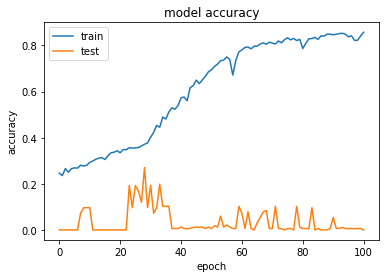

In [397]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

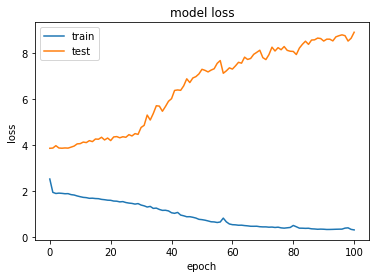

In [398]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

In [399]:

def playNote(nota):
    PyAudio = pyaudio.PyAudio     #initialize pyaudio

    #See https://en.wikipedia.org/wiki/Bit_rate#Audio
    BITRATE = 56000     #number of frames per second/frameset.      

    FREQUENCY = nota     #Hz, waves per second, 261.63=C4-note.
    LENGTH = 0.05     #seconds to play sound

    if FREQUENCY > BITRATE:
        BITRATE = FREQUENCY+100

    NUMBEROFFRAMES = int(BITRATE * LENGTH)
    RESTFRAMES = NUMBEROFFRAMES % BITRATE
    WAVEDATA = ''    

    #generating wawes
    for x in range(NUMBEROFFRAMES):
     WAVEDATA = WAVEDATA+chr(int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128))    

    for x in range(RESTFRAMES): 
     WAVEDATA = WAVEDATA+chr(128)

    p = PyAudio()
    stream = p.open(format = p.get_format_from_width(1), 
                    channels = 1, 
                    rate = BITRATE, 
                    output = True)

    stream.write(WAVEDATA)
    stream.stop_stream()
    stream.close()
    p.terminate()

- Teste

In [400]:

testText = open('predict.txt', 'r', encoding='utf-8').read()

dataTestX = []
seq_in = testText[0: seq_length].lower()

dataTestX.append([char_to_int[char] for char in seq_in])

In [401]:
print(seq_in)

*-/44


In [402]:
testX = numpy.reshape(dataTestX, (1, seq_length, 1))

prediction = model.predict(testX, verbose=0)
index = numpy.argmax(prediction)
print(int_to_char[index])

7


In [403]:
resultado = ""
for i in range(100):
    testX = numpy.reshape(dataTestX, (1, seq_length, 1))

    prediction = model.predict(testX, verbose=0)
    index = numpy.argmax(prediction)
    
    resultado += int_to_char[index]
    
    dataTestX[0].pop(0) 
    dataTestX[0].append(index)



In [404]:
resultado
                        

'774/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/'

In [405]:
print(seq_in + resultado)

*-/44774/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/4/+-+*+/6/67974/+(*(#*+-/+-/


In [411]:
musica = ""
for char in resultado:
    musica += notas.loc[notas['Número da tecla'] == ord(char)]['Notação científica (SPN)'].values[0]+"-"
print(musica)    

D♯5/E♭5 D♯5/E♭5 C5 G4 D♯4/E♭4 C4 D4 C4 G3 D4 D♯4/E♭4 F4 G4 D♯4/E♭4 F4 G4 C5 G4 D♯4/E♭4 F4 D♯4/E♭4 D4 D♯4/E♭4 G4 D5 G4 D5 D♯5/E♭5 F5 D♯5/E♭5 C5 G4 D♯4/E♭4 C4 D4 C4 G3 D4 D♯4/E♭4 F4 G4 D♯4/E♭4 F4 G4 C5 G4 D♯4/E♭4 F4 D♯4/E♭4 D4 D♯4/E♭4 G4 D5 G4 D5 D♯5/E♭5 F5 D♯5/E♭5 C5 G4 D♯4/E♭4 C4 D4 C4 G3 D4 D♯4/E♭4 F4 G4 D♯4/E♭4 F4 G4 C5 G4 D♯4/E♭4 F4 D♯4/E♭4 D4 D♯4/E♭4 G4 D5 G4 D5 D♯5/E♭5 F5 D♯5/E♭5 C5 G4 D♯4/E♭4 C4 D4 C4 G3 D4 D♯4/E♭4 F4 G4 D♯4/E♭4 F4 G4 


In [ ]:

for char in resultado:
    freq = notas.loc[notas['Número da tecla'] == ord(char)]['Frequência (Hz)'].values[0].replace(",",".")
    playNote(float(freq))